In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import datetime as dt
#df = pd.read_csv("../five_min_frame.csv")

In [6]:
import csv
with open("../five_min_frame.csv") as f:
    reader = csv.reader(f)
    for row in reader:
        # do something here with `row`
        print row
        break

['', 'Timestamp', 'Station', 'District', 'Freeway #', 'Direction', 'Lane Type', 'Station Length', 'Samples', '% Observed', 'Total Flow', 'Avg Occupancy', 'Avg Speed']


In [7]:
iter_csv = pd.read_csv("../five_min_frame.csv", iterator=True, chunksize=1000)
#df = pd.concat([chunk[chunk['Station'] == 1108291] for chunk in iter_csv])

In [13]:
a = time.time()
list_of_good = []
for chunk in iter_csv:
    small_df = chunk.ix[chunk['Station'] == 1108291,:]
    list_of_good.append(small_df)
df = pd.concat(list_of_good)
b = time.time()
print b-a

618.95382309


In [102]:
#df2 = df.copy()
df = df2.copy()

In [104]:
df.columns

Index([u'Unnamed: 0', u'Timestamp', u'Station', u'District', u'Freeway #',
       u'Direction', u'Lane Type', u'Station Length', u'Samples',
       u'% Observed', u'Total Flow', u'Avg Occupancy', u'Avg Speed'],
      dtype='object')

In [105]:
df = df.reset_index(drop=True)

In [106]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [107]:
df.ix[df.index == 93,'Timestamp'].apply(lambda x: type(x))

93    <class 'pandas.tslib.Timestamp'>
Name: Timestamp, dtype: object

In [108]:
#df['Timestamp'] = df['Timestamp'].apply()

In [109]:
df['Time'],df['Date']= df['Timestamp'].apply(lambda x:x.time()), df['Timestamp'].apply(lambda x:x.date())

In [110]:
df = df[['Date','Time','Station','Total Flow']]
df=df.sort_values(['Date','Time'])
data = df.as_matrix()

rows, row_pos = np.unique(data[:, 1], return_inverse=True) #Time
cols, col_pos = np.unique(data[:, 2], return_inverse=True)
depth, depth_pos = np.unique(data[:, 0], return_inverse=True) 

pivot_table = np.zeros((len(rows), len(cols), len(depth)), dtype=data.dtype)
pivot_table[row_pos, col_pos, depth_pos] = data[:, 3]

a = pivot_table; # example of what real input will look like

# create 2D flattened version of 3D input array
d1,d2,d3 = a.shape
b = np.zeros([d1,d2*d3])
for i in range(len(a)):
    b[i] = a[i].flatten()

In [111]:
b

array([[  53.,   43.,   78., ...,   43.,   43.,   53.],
       [  38.,   61.,   71., ...,   42.,   50.,   53.],
       [  50.,   57.,   73., ...,   45.,   40.,   46.],
       ..., 
       [  65.,   84.,   95., ...,   87.,    0.,  103.],
       [  59.,   92.,  103., ...,   53.,    0.,  107.],
       [  56.,   82.,   95., ...,   64.,    0.,   92.]])

### Generic

In [112]:
from sklearn.cluster import KMeans
kmeans = KMeans()
my_fit = kmeans.fit(b.transpose())

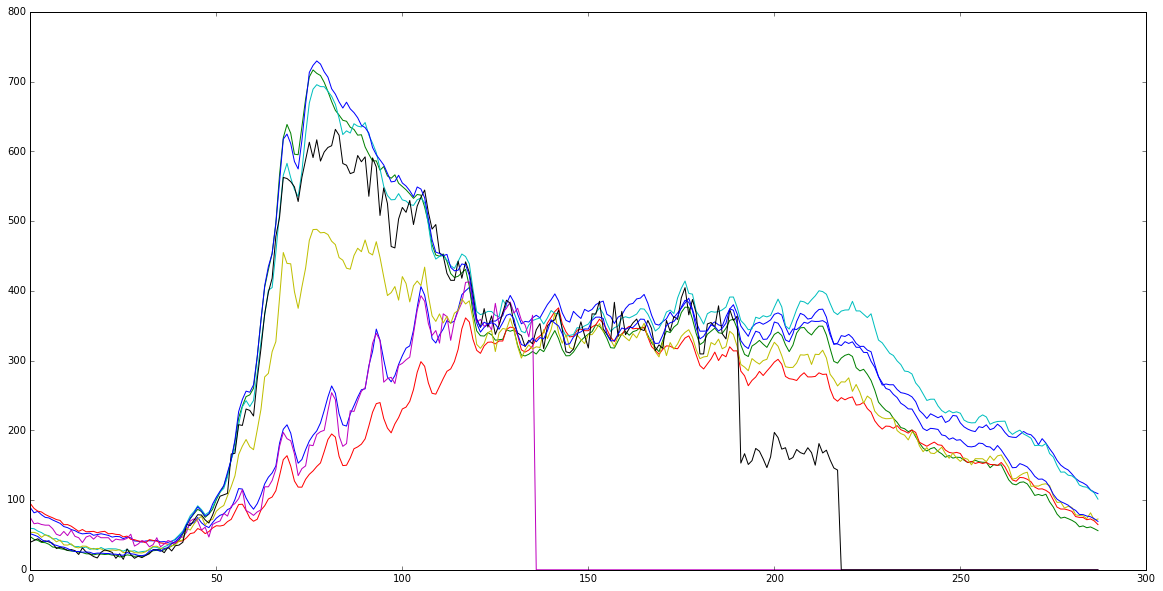

In [113]:
plt.figure(figsize = (20,10))
plt.plot(my_fit.cluster_centers_.transpose())
plt.show() # these are the centers

### Elbow

In [114]:
KMeans?

In [115]:
KMeans().fit

<bound method KMeans.fit of KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=8, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)>

In [116]:
inertia_list = []
for i in range(2,20):
    kmeans = KMeans(n_clusters = i)
    my_fit = kmeans.fit(b.transpose())
    inertia = my_fit.inertia_
    inertia_list.append([i,inertia])

In [117]:
my_fit.inertia_

67256775.040442199

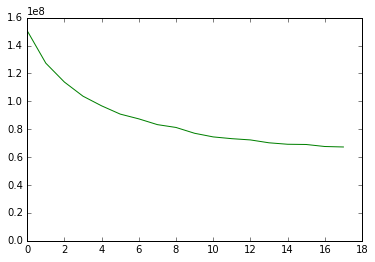

In [118]:
plt.plot(inertia_list)

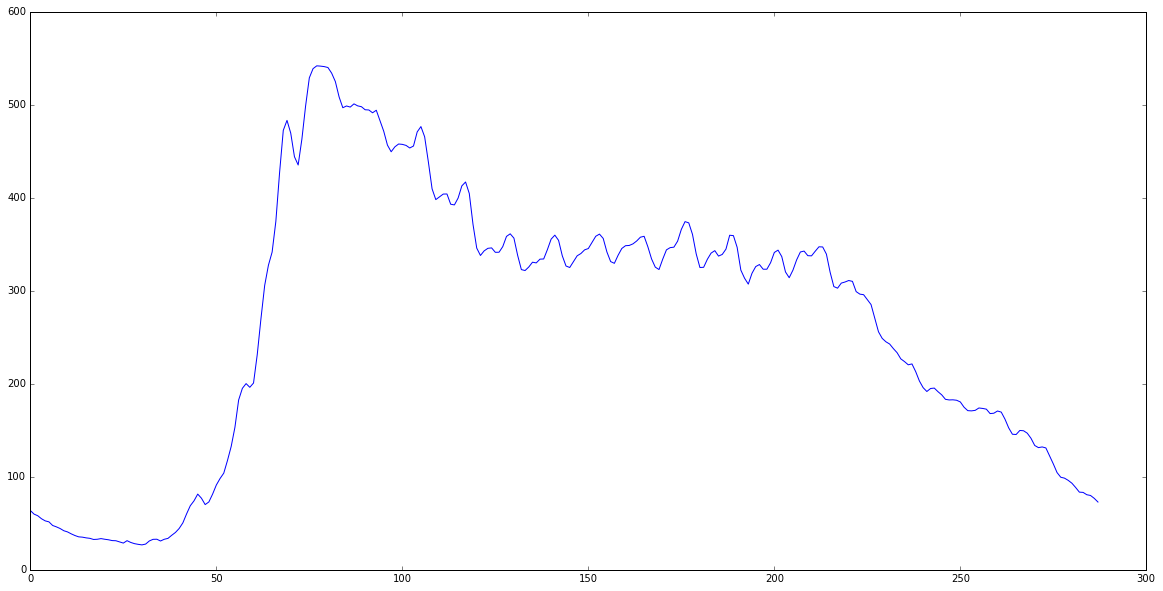

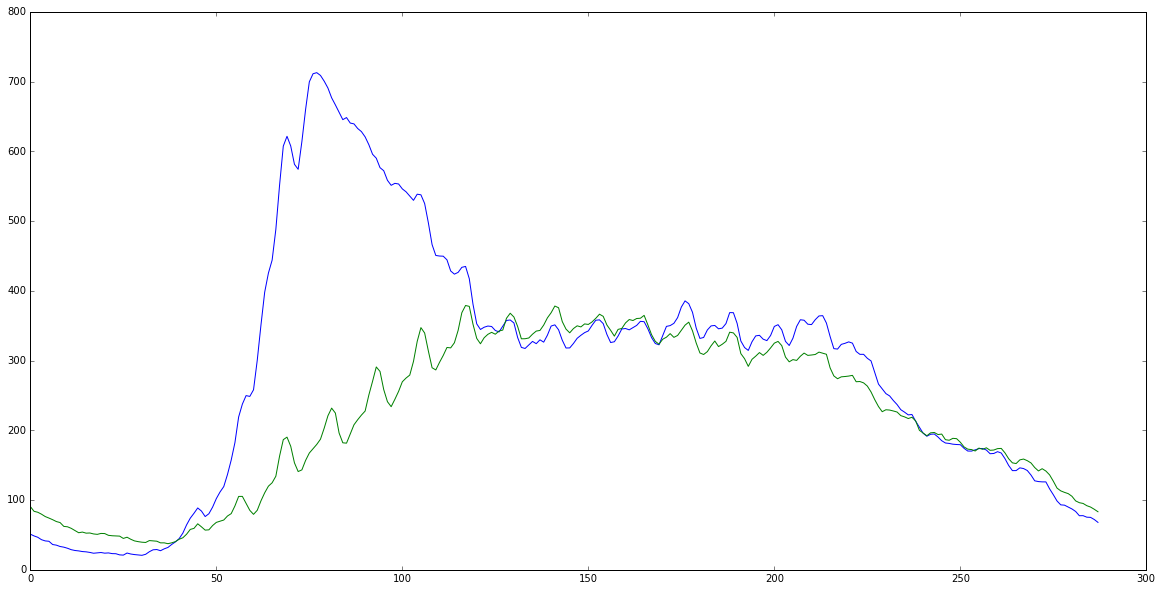

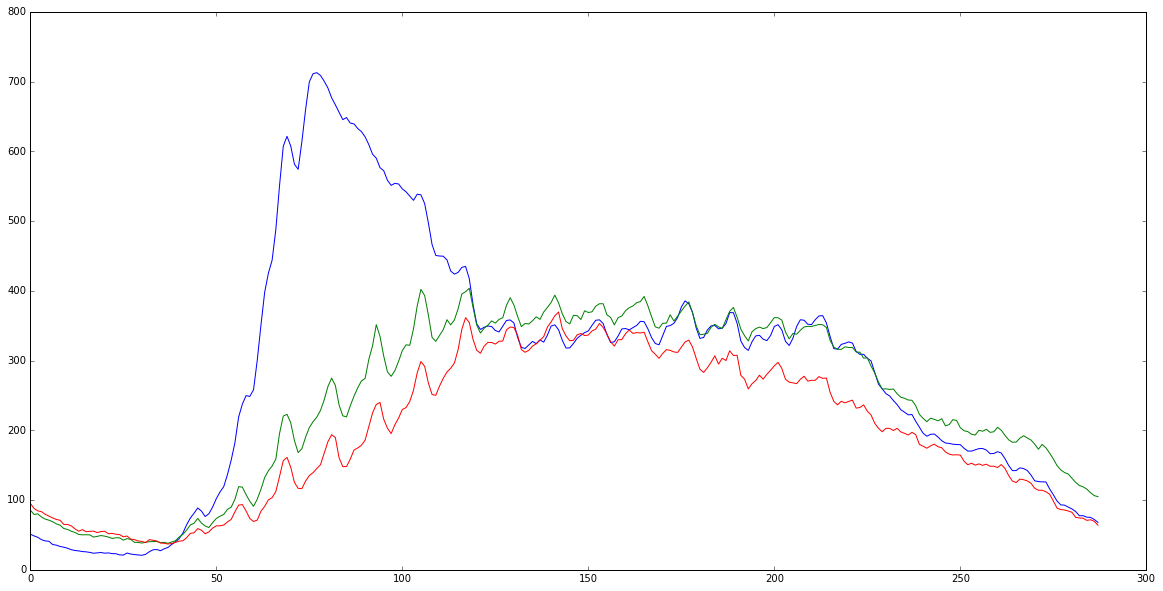

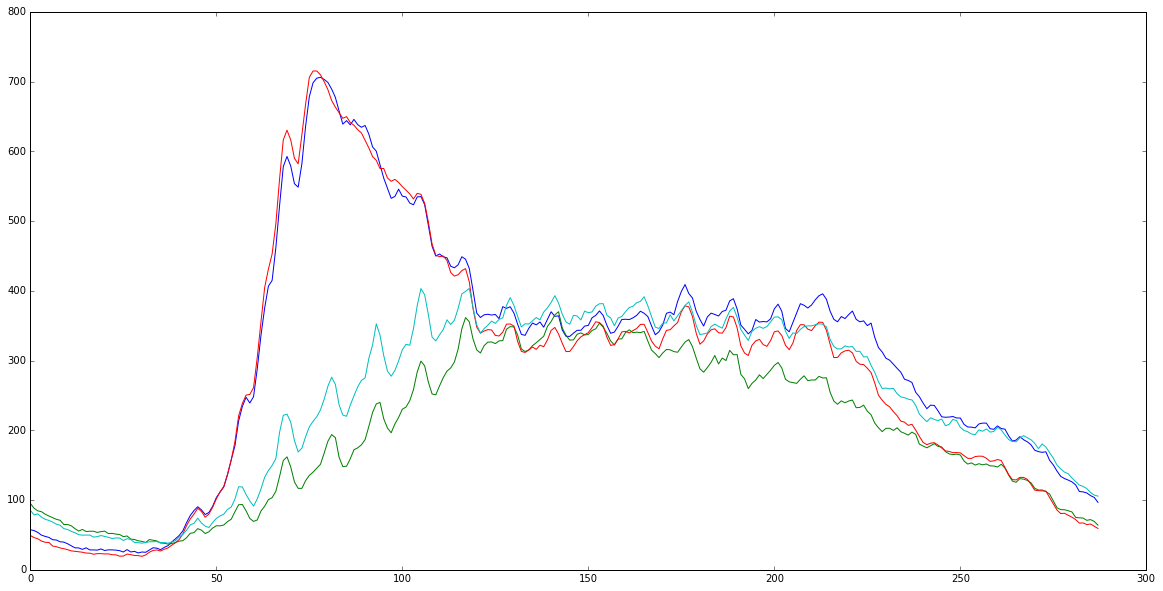

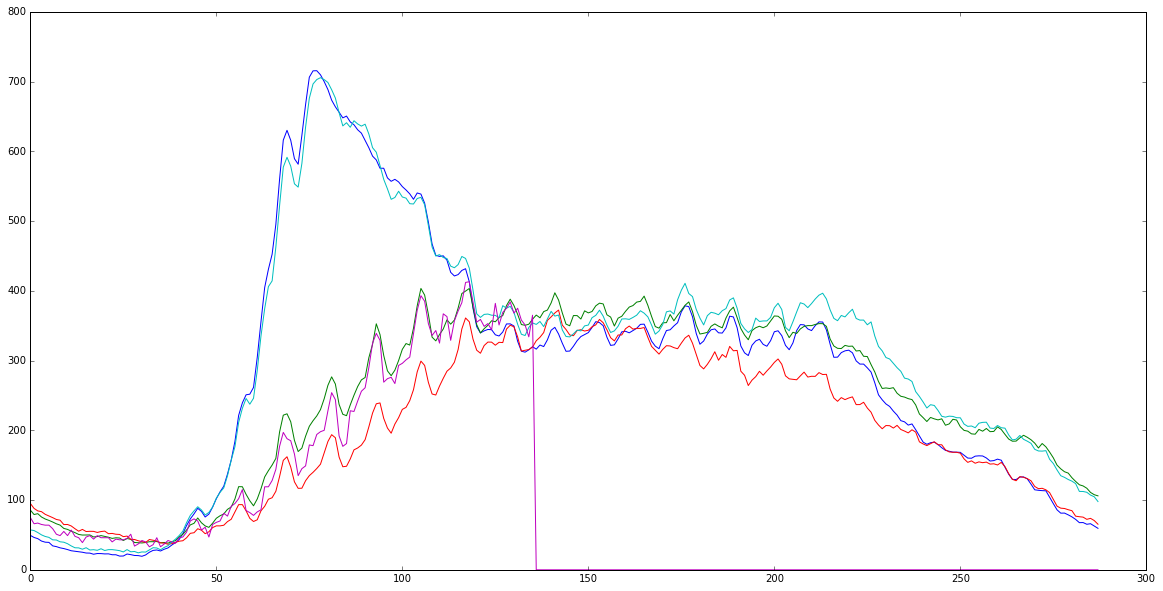

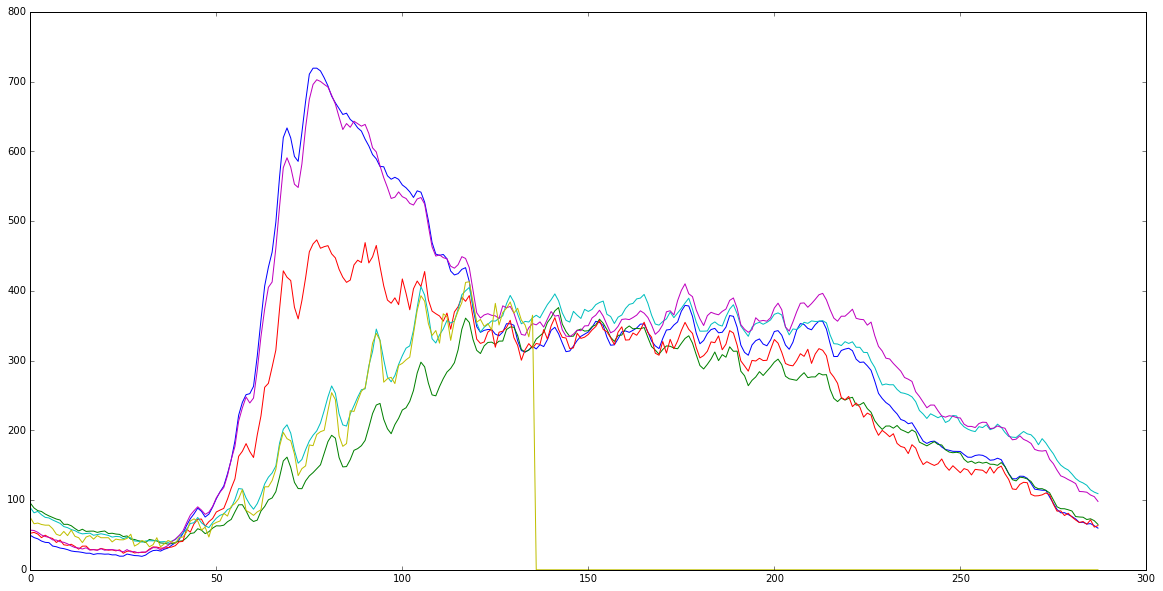

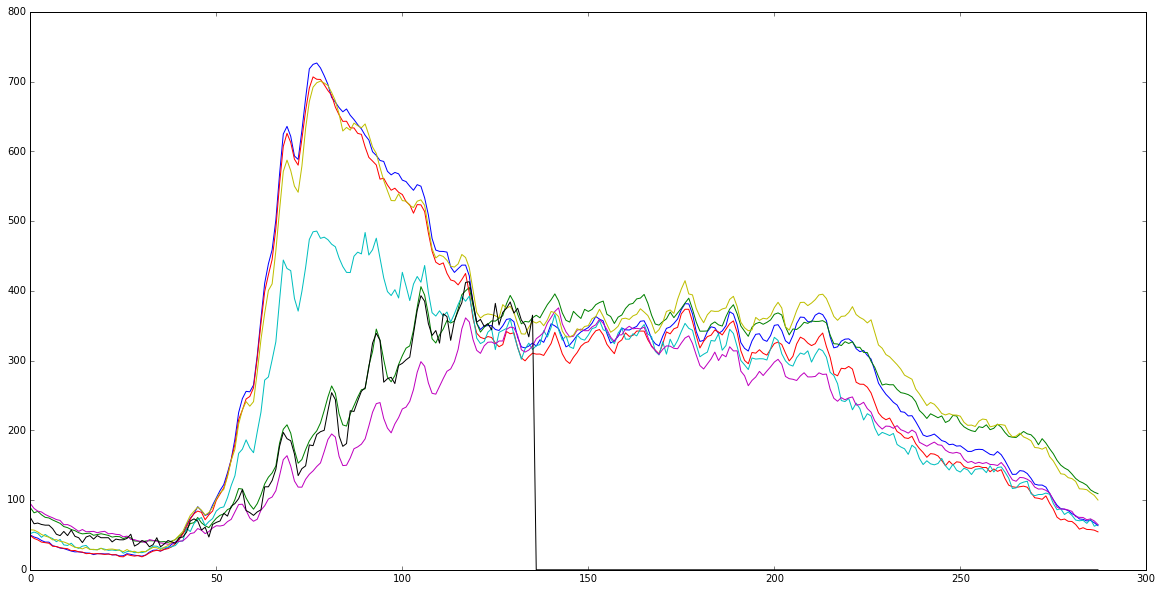

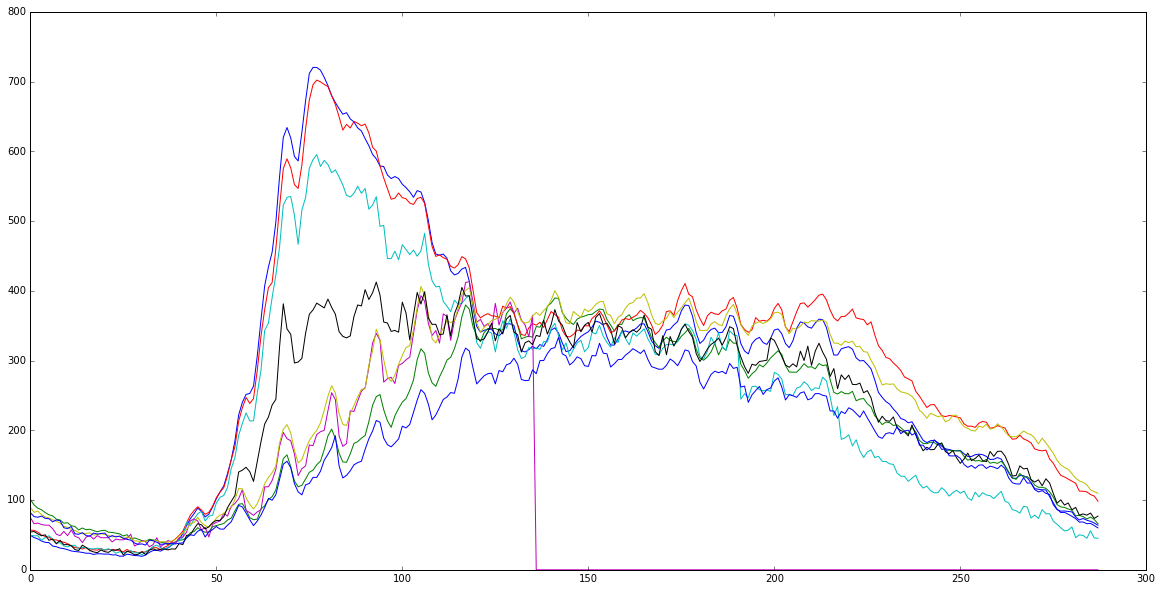

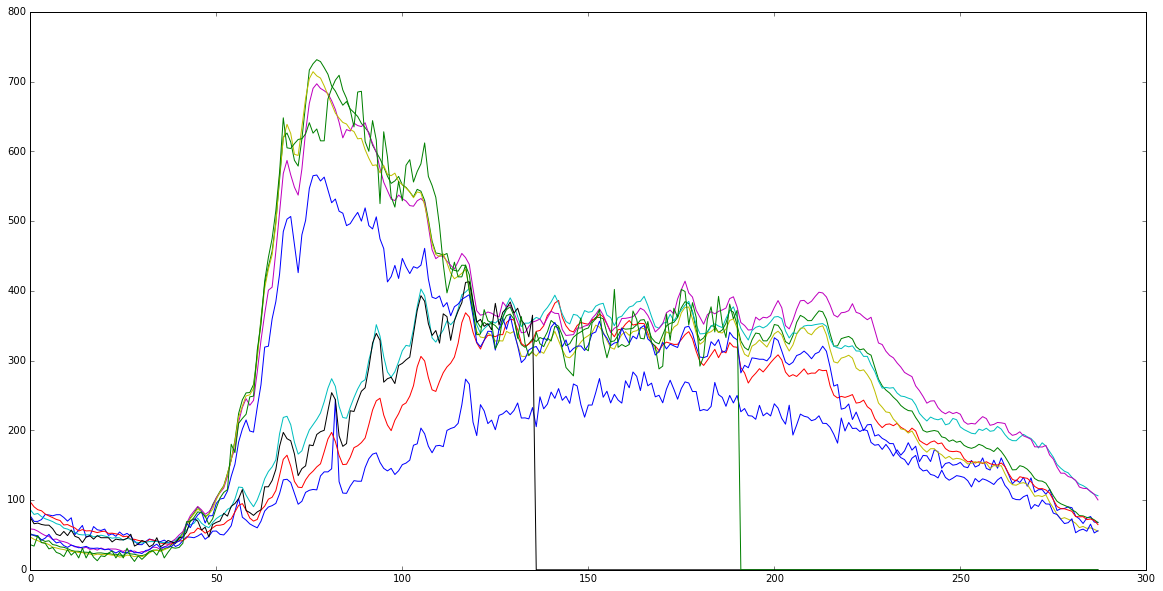

In [119]:
for i in range(1,10):
    kmeans = KMeans(n_clusters = i)
    my_fit = kmeans.fit(b.transpose())
    plt.figure(figsize = (20,10))
    plt.plot(my_fit.cluster_centers_.transpose())
    plt.show() # these are the centers

Two clusters seems compelling!  Lets see what composes the two clusters.

### Demo that days are the same

In [147]:
for i in range(365):
    try:
        date = dt.date(2015,1,1)
        date = date + dt.timedelta(days=i)
        mini_df = df.ix[df.Date == date,'Total Flow']
        #mini_df = range(288)
        tests = [True for elem in (mini_df-b.transpose()[i]) if elem == 0]
        if tests != [True for i in range(288)]:
            print "{} is a not good point".format(str(i))
    except: 
        print "{} is a bad point".format(str(i))

33 is a bad point
58 is a bad point
66 is a bad point
363 is a bad point


### Two cluster analysis

In [240]:
kmeans = KMeans(n_clusters = 2)
my_fit = kmeans.fit(b.transpose())

In [241]:
cluster_pred = kmeans.fit_predict(b.transpose())

In [166]:
week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',  'Friday', 'Saturday','Sunday']

In [197]:
day_list = []
date_list = []
for i in range(365):
    date = dt.date(2015,1,1)
    date = date + dt.timedelta(days=i)
    day_name = week[date.weekday()]
    day_list.append(day_name)
    date_list.append(date)

In [202]:
holidays = pd.read_csv('../Holidays.csv')

In [214]:
holidays['Date'] =  pd.to_datetime(holidays['Date'])
holidays['Date'] = holidays['Date'].apply(lambda x:x.date())
holidays = holidays[['Date','HolidayName']]

In [215]:
holidays.Date[0]

datetime.date(2012, 1, 2)

In [216]:
my_df = pd.DataFrame({"Cluster":cluster_pred, "DayName":day_list, "Date":date_list})

In [217]:
#for colnames in my_df.columns[1:]:
    

In [219]:
my_df = my_df.merge(holidays,how='left')

In [228]:
idx1 = ~my_df.HolidayName.isnull()
idx2 = my_df.DayName.isin(['Sunday','Saturday'])
my_df['HolidayOrWeekend'] = idx1 | idx2

In [235]:
good = ((my_df.HolidayOrWeekend == True) & (my_df.Cluster == 0)) | ((my_df.HolidayOrWeekend == False) & (my_df.Cluster == 1))

In [237]:
sum(good)

360

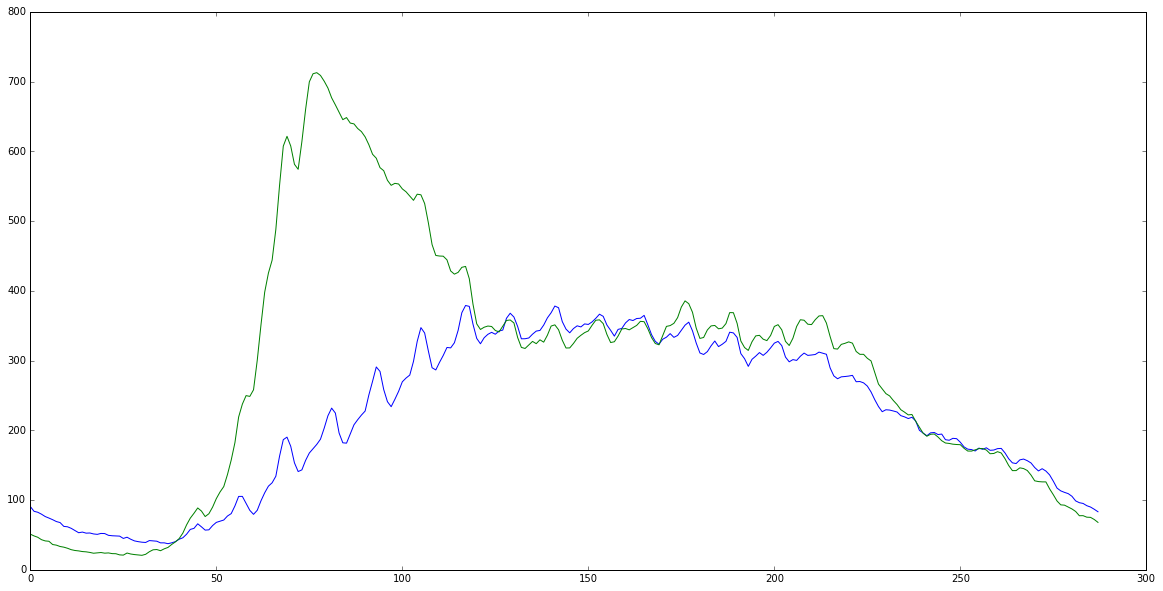

In [242]:

plt.show() # these are the centers

In [254]:
bads = [i for i,bool in good.iteritems() if bool==False]
    

(5, 288)

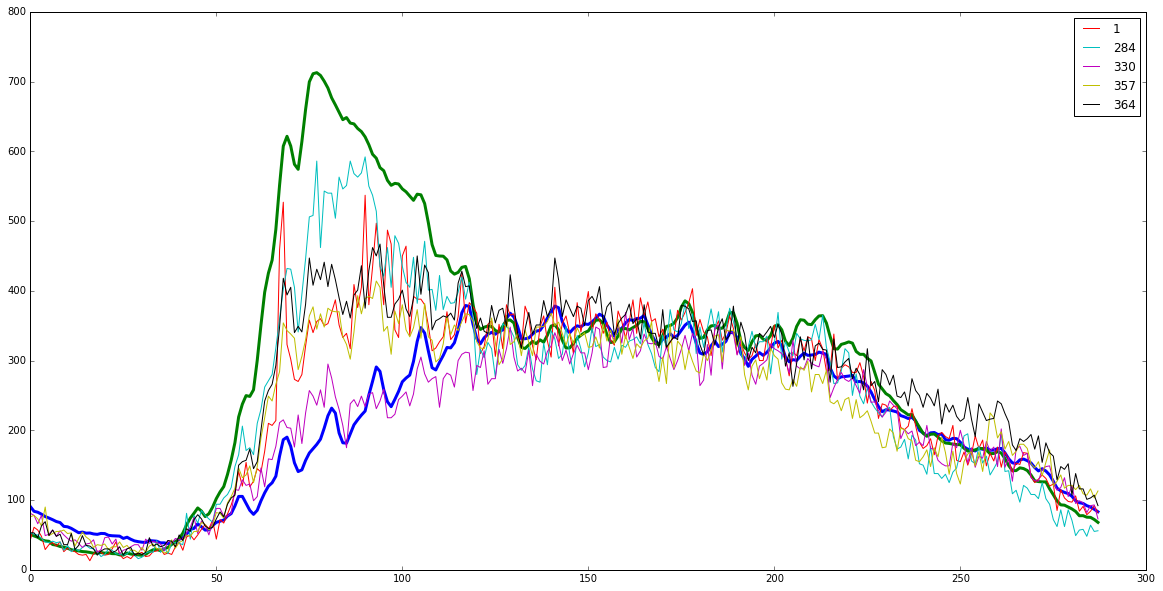

In [268]:
plt.figure(figsize = (20,10))
plt.plot(my_fit.cluster_centers_.transpose(), linewidth=3)
for i,j in enumerate(bads):
    plt.plot(b.transpose()[j], label = str(j))

plt.legend()
plt.show()